In [397]:
import gc
import random
import datetime
import glob
import re

from collections import defaultdict
from tqdm import tqdm

import numpy as np
import pandas as pd

import plotly.graph_objects as go
import matplotlib.pyplot as plt

from scipy.stats import pearsonr

import hashlib
import networkx as nx
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

def unixtime_to_date(unix_timestamp):
    """Converts a Unix timestamp to a human-readable date."""
    return datetime.datetime.fromtimestamp(unix_timestamp).strftime('%Y-%m-%d %H:%M:%S')

def extract_number_from_string(string):
    """
    Extracts a number from a string using regular expressions.
    Returns the extracted number as a string.
    """
    pattern = r"/(\d+)/\d+_label.csv$"
    match = re.search(pattern, string)
    if match:
        return match.group(1)
    else:
        return None
    
def applyint(df:pd.DataFrame,column:str):
    return df[column].apply(lambda x : int(x))

# data load and preprocessing

In [398]:
survey = pd.read_csv('/home/agens/it/pjt/lifelog/input/user_survey_2020.csv')
sleep = pd.read_csv('/home/agens/it/pjt/lifelog/input/user_sleep_2020.csv')
info = pd.read_csv('/home/agens/it/pjt/lifelog/input/user_info_2020.csv')

In [399]:
userId = 'user01'
usersleepdf = sleep[sleep[f'userId'] == f'{userId}'][['userId','date','sleep_score']].set_index('userId').drop_duplicates('date')

folderList = glob.glob(f'/home/agens/it/pjt/lifelog/input/{userId}/*')
databox = defaultdict(pd.DataFrame)
fileList = []
fileList.append([glob.glob(folderList[i] + '/*.csv')[0] for i in range(len(folderList))])

for i in tqdm(range(len(fileList[0]))):
    databox[extract_number_from_string(fileList[0][i])] = pd.read_csv(fileList[0][i])

100%|██████████| 21/21 [00:00<00:00, 397.40it/s]


In [400]:
userdf = pd.concat(databox,ignore_index=True)
userdf['name'] = f'{userId}'
userdf['date'] = userdf['ts'].apply(lambda x : unixtime_to_date(x))
userdf = userdf.sort_values('date').reset_index(drop=True)
userdf['day'] = userdf['date'].apply(lambda x : x[:10])
userdf['time'] = userdf['date'].apply(lambda x : x[10:])

In [401]:
breifColumn = ['day','time','name','action','place','condition','emotionPositive','emotionTension']
daybox = defaultdict(pd.DataFrame)
for dat in userdf['day'].unique():
    daybox[dat] = userdf[userdf['day'] == dat][breifColumn]

gc.collect()

53727

## analytics result

## action only

In [402]:
# action box build
actionbox = defaultdict()
topnumber = 1
try:
    # iter the day
    for dat in list(daybox.keys()):
        actionbox[dat] = {}
        # load the value
        for action , value in (daybox[dat]['action'].value_counts() / daybox[dat]['action'].value_counts().sum()).items():
            actionbox[dat][action] = value
        # top 3 value check
        # print(dat , dict(list(actionbox[dat].items())[:3]))
        actionbox[dat][f'top{topnumber}sum'] = sum(dict(list(actionbox[dat].items())[:topnumber]).values())
        # top_3_items = dict(list(data.items())[:3])
except:
    pass

behaviorstatdf = pd.DataFrame.from_dict(actionbox)

hypo1 = pd.merge(behaviorstatdf.T.reset_index()[['index',f'top{topnumber}sum']].rename(columns={'index':'date'}), usersleepdf)
hypo1 = hypo1.dropna().drop_duplicates().sort_values('date')
display(hypo1)
pearsonr(x = hypo1[f'top{topnumber}sum'] , y = hypo1['sleep_score'])

,date,top1sum,sleep_score
0,2020-08-31,0.308087,83
1,2020-09-05,0.293696,79
2,2020-09-07,0.225718,20
3,2020-09-08,0.249554,83
4,2020-09-09,1.000000,51
5,2020-09-12,0.258454,93
6,2020-09-13,0.273556,71
7,2020-09-14,0.277686,86
8,2020-09-15,0.446809,47
9,2020-09-19,0.272873,50


PearsonRResult(statistic=-0.3469805987400088, pvalue=0.15833023353696263)

## Combined both action , condition , place

In [403]:
usercolumn = ['action','place','condition']

# action box build
actionbox = defaultdict()
conditionbox = defaultdict()
placebox = defaultdict()
topnumber = 3
try:
    # iter the day
    for dat in list(daybox.keys()):
        actionbox[dat] = {}
        conditionbox[dat] = {}
        placebox[dat] = {}
        # load the value
        for col in usercolumn[:3]:
            for action , value in (daybox[dat][col].value_counts() / daybox[dat][col].value_counts().sum()).items():
                actionbox[dat][action] = value
        # top 3 value check
        # print(dat , dict(list(actionbox[dat].items())[:3]))
        actionbox[dat][f'top{topnumber}sum'] = sum(dict(list(actionbox[dat].items())[:topnumber]).values())
        # top_3_items = dict(list(data.items())[:3])
except:
    pass

behaviorstatdf = pd.DataFrame.from_dict(actionbox).fillna(0)


<Axes: title={'center': 'user01 sleep score'}, xlabel='date'>

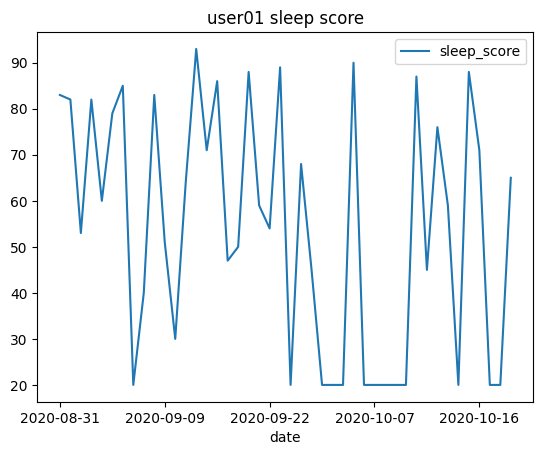

In [404]:
# sleep quliaty
sleep[sleep['userId'] == 'user01'][['userId','date','sleep_score']].set_index('userId').plot(x='date',y='sleep_score',title=f"{userdf['name'].unique()[0]} sleep score")

# sankey visualization

In [405]:
usercolumn = ['name','action', 'place', 'condition']
day = np.random.choice(userdf['day'].unique())
allBehavior = np.concatenate([userdf[usercolumn].iloc[:,i].unique() for i in range(len(usercolumn))])
mappingDict = {beh : idx for idx , beh in enumerate(allBehavior)}
edgeweightMapping = behaviorstatdf[day].to_dict()

# user behavior history
# display(daybox[day].drop_duplicates(subset=['name','action','place','condition']))

behaviorList = []
for row in daybox[day].drop_duplicates(subset=['name','action','place','condition']).iterrows():
    #print(row[1][2:6].values)
    behaviorList.append(row[1][2:6].values)

daydf = pd.DataFrame(behaviorList,columns=['name','action','place','condition'])

for col in daydf.columns[1:]:
    daydf[f'm_{col}'] = daydf[col].apply(lambda x : mappingDict[x])
    daydf[f'e_{col}'] = daydf[col].apply(lambda x : edgeweightMapping[x])

# for edgeweight
daydf['e_actionplace'] , daydf['e_placeconditon'] = daydf['e_action'].values * daydf['e_place'] , daydf['e_place'].values * daydf['e_condition']

source_ = []
target_ = []
value_ = []

# for networkx 
for rows in daydf.iterrows():
    source_.append((list(rows[1][['m_action','m_place']].values))[0])
    target_.append((list(rows[1][['m_action','m_place']].values))[1])
    value_.append((list(rows[1][['e_actionplace']].values)))
    source_.append((list(rows[1][['m_place','m_condition']].values))[0])
    target_.append((list(rows[1][['m_place','m_condition']].values))[1])
    value_.append((list(rows[1][['e_placeconditon']].values)))
    

assert daydf['e_action'].unique().sum() == 1.0
assert daydf['e_condition'].unique().sum() == 1.0
assert daydf['e_place'].unique().sum() == 1.0

# Define the number of colors to generate
num_colors = len(list(mappingDict.keys()))

# Generate a set of random colors based on the number of labels
colors = [f'rgba({random.randint(0, 255)}, {random.randint(0, 255)}, {random.randint(0, 255)}, 0.8)' for i in range(num_colors)]

fig = go.Figure(data=[go.Sankey(
    node = dict(
      pad = 15,
      thickness = 20,
      line = dict(color = "black", width = 0.5),
      label = list(mappingDict.keys()),
      color = colors
    ),
    link = dict(
      source = source_, # indices correspond to labels, eg A1, A2, A1, B1, ...
      target = target_,
      value = value_
  ))])

fig.update_layout(title_text=f"{userdf['name'].unique()[0]} {day} Sankey Diagram", font_size=25)
fig.show()

# graph visualization

## depth mapping

In [406]:
depthmappingDict = {}
depthmappingDict[0] = {act : 0 for act in userdf['action'].unique()}
depthmappingDict[1] = {act : 1 for act in userdf['place'].unique()}
depthmappingDict[2] = {act : 2 for act in userdf['condition'].unique()}
depthmappgingDict_ = dict(depthmappingDict[0] , **depthmappingDict[1], **depthmappingDict[2])

reversedDict = {value : key for key , value in mappingDict.items()}
depthmappingDictFinal = dict(zip(list(map(mappingDict.get, list(depthmappgingDict_.keys()))) , list(depthmappgingDict_.values())))

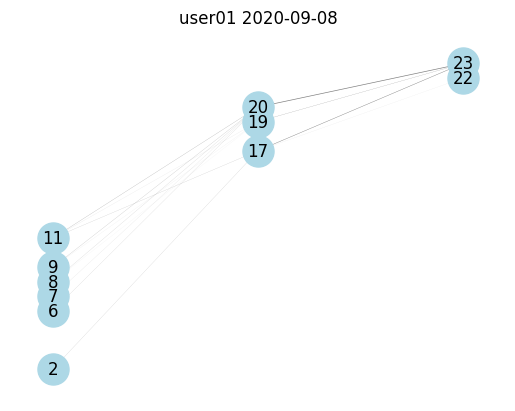

In [408]:
G = nx.Graph()
G.add_weighted_edges_from(list(zip(source_,target_, sum(value_, []))))
edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
depths = dict(zip(list(G.nodes()) , list(map(depthmappingDictFinal.get, list(G.nodes())))))
# Define node positions based on depth
pos = {}
for node, depth in depths.items():
    pos[node] = (depth, node)

plt.figure()
plt.title(f"{userdf['name'].unique()[0]} {day}")
nx.draw(G, pos=pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray',width=edge_weights)
#nx.draw(DG, with_labels=True, width=edge_weights)

## user node addition visualization version

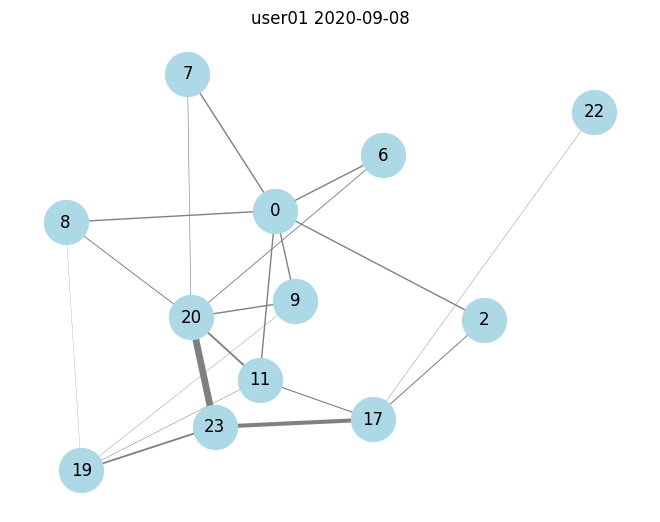

In [417]:
DG = nx.Graph()
DG.add_weighted_edges_from(list(zip(source_,target_, sum(value_, []))))
usernodenum = 0
DG.add_node(usernodenum)
intersec = set(daydf['m_action'].values).intersection(set(list(DG.nodes())))
DG.add_weighted_edges_from(list(zip([usernodenum] * len(intersec), list(intersec), [float(0.1)] * len(intersec))))

#edge_weights = [DG[u][v]['weight'] for u, v in DG.edges()]
# Calculate edge thickness based on edge weights
scaling_factor = 10
edge_widths = [scaling_factor * DG.edges[u, v]['weight'] for u, v in DG.edges()]
# Set a random seed for reproducibility
#seed_value = 2023
#pos = nx.spring_layout(DG,seed=seed_value)
#pos = nx.circular_layout(DG)
# Compute the layout using tree layout algorithm
#pos = nx.nx_agraph.graphviz_layout(DG, prog='dot')
# Compute the layout using circular tree layout algorithm
#pos = nx.nx_agraph.graphviz_layout(DG, prog='twopi')

nx.draw(DG, with_labels=True, node_color='lightblue', node_size=1000, edge_color='gray',width=edge_widths)
plt.title(f"{userdf['name'].unique()[0]} {day}")
plt.show()

## graph build

### graph

## usernode non-addition

In [ ]:
graphs = defaultdict()

for day in tqdm(sorted(userdf['day'].unique())):
    graphs[day] = {}
    allBehavior = np.concatenate([userdf[usercolumn].iloc[:,i].unique() for i in range(len(usercolumn))])
    mappingDict = {beh : idx for idx , beh in enumerate(allBehavior)}
    edgeweightMapping = behaviorstatdf[day].to_dict()
    edgeweightMapping[f'{userId}'] = 1
    # user behavior history
    # display(daybox[day].drop_duplicates(subset=['name','action','place','condition']))

    behaviorList = []
    for row in daybox[day].drop_duplicates(subset=['name','action','place','condition']).iterrows():
        #print(row[1][2:6].values)
        behaviorList.append(row[1][2:6].values)
    #    codes, uniques = pd.factorize(row[1][2:6].values)

    daydf = pd.DataFrame(behaviorList,columns=['name','action','place','condition'])

    for col in daydf.columns:
        daydf[f'm_{col}'] = daydf[col].apply(lambda x : mappingDict[x])
        daydf[f'e_{col}'] = daydf[col].apply(lambda x : edgeweightMapping[x])

    # for edgeweight
    daydf['e_actionplace'] , daydf['e_placeconditon'] = daydf['e_action'].values * daydf['e_place'] , daydf['e_place'].values * daydf['e_condition']

    source_ = []
    target_ = []
    value_ = []

    # for networkx 
    for rows in daydf.iterrows():
        source_.append((list(rows[1][['m_name','m_action']].values))[0])
        target_.append((list(rows[1][['m_name','m_action']].values))[1])
        source_.append((list(rows[1][['m_action','m_place']].values))[0])
        target_.append((list(rows[1][['m_action','m_place']].values))[1])
        value_.append((list(rows[1][['e_actionplace']].values)))
        source_.append((list(rows[1][['m_place','m_condition']].values))[0])
        target_.append((list(rows[1][['m_place','m_condition']].values))[1])
        value_.append((list(rows[1][['e_placeconditon']].values)))

        G = nx.Graph()
        G.add_weighted_edges_from(list(zip(source_,target_, sum(value_, []))))
        

        # node attribute data structure unities
        daydf['m_action'] = applyint(df=daydf, column='m_action')
        daydf['m_place'] = applyint(df=daydf, column='m_place')
        daydf['m_condition'] = applyint(df=daydf, column='m_condition')

        left_columns = ['m_action','m_place','m_condition']
        right_columns = ['e_action','e_place','e_condition']

        node_attrs = defaultdict()

        for key , value in dict(zip(left_columns, right_columns)).items():
            for cnt in range(daydf.shape[0]):
                node_attrs[daydf[key].values[cnt]] = {'feature' : str(daydf[value].values[cnt])}
        
        # for ego_node
        node_attrs[0] = dict()
        node_attrs[0]['feature'] = str(1.0)
        nx.set_node_attributes(G, node_attrs)

        graphs[day] = G

100%|██████████| 21/21 [00:01<00:00, 17.65it/s]


## usernode addition

In [ ]:
graphs = defaultdict()

for day in tqdm(sorted(userdf['day'].unique())):
    graphs[day] = {}
    allBehavior = np.concatenate([userdf[usercolumn].iloc[:,i].unique() for i in range(len(usercolumn))])
    mappingDict = {beh : idx for idx , beh in enumerate(allBehavior)}
    edgeweightMapping = behaviorstatdf[day].to_dict()
    edgeweightMapping[f'{userId}'] = 1
    # user behavior history
    # display(daybox[day].drop_duplicates(subset=['name','action','place','condition']))

    behaviorList = []
    for row in daybox[day].drop_duplicates(subset=['name','action','place','condition']).iterrows():
        #print(row[1][2:6].values)
        behaviorList.append(row[1][2:6].values)
    #    codes, uniques = pd.factorize(row[1][2:6].values)

    daydf = pd.DataFrame(behaviorList,columns=['name','action','place','condition'])

    for col in daydf.columns:
        daydf[f'm_{col}'] = daydf[col].apply(lambda x : mappingDict[x])
        daydf[f'e_{col}'] = daydf[col].apply(lambda x : edgeweightMapping[x])

    # for edgeweight
    daydf['e_actionplace'] , daydf['e_placeconditon'] = daydf['e_action'].values * daydf['e_place'] , daydf['e_place'].values * daydf['e_condition']

    source_ = []
    target_ = []
    value_ = []

    # for networkx 
    for rows in daydf.iterrows():
        source_.append((list(rows[1][['m_name','m_action']].values))[0])
        target_.append((list(rows[1][['m_name','m_action']].values))[1])
        source_.append((list(rows[1][['m_action','m_place']].values))[0])
        target_.append((list(rows[1][['m_action','m_place']].values))[1])
        value_.append((list(rows[1][['e_actionplace']].values)))
        source_.append((list(rows[1][['m_place','m_condition']].values))[0])
        target_.append((list(rows[1][['m_place','m_condition']].values))[1])
        value_.append((list(rows[1][['e_placeconditon']].values)))

        G = nx.Graph()
        G.add_weighted_edges_from(list(zip(source_,target_, sum(value_, []))))
        usernodenum = 0
        G.add_node(usernodenum)
        intersec = set(daydf['m_action'].values).intersection(set(list(DG.nodes())))
        G.add_weighted_edges_from(list(zip([usernodenum] * len(intersec), list(intersec), [float(0.1)] * len(intersec))))

        # node attribute data structure unities
        daydf['m_action'] = applyint(df=daydf, column='m_action')
        daydf['m_place'] = applyint(df=daydf, column='m_place')
        daydf['m_condition'] = applyint(df=daydf, column='m_condition')

        left_columns = ['m_action','m_place','m_condition']
        right_columns = ['e_action','e_place','e_condition']

        node_attrs = defaultdict()

        for key , value in dict(zip(left_columns, right_columns)).items():
            for cnt in range(daydf.shape[0]):
                node_attrs[daydf[key].values[cnt]] = {'feature' : str(daydf[value].values[cnt])}
        
        # for ego_node
        node_attrs[0] = dict()
        node_attrs[0]['feature'] = str(1.0)
        nx.set_node_attributes(G, node_attrs)

        graphs[day] = G

100%|██████████| 21/21 [00:01<00:00, 17.43it/s]


## graph embedding

In [ ]:
## vector_size ; number of dimension
## workers ; number of workers.(resource)
## epochs ; number of training epochs.
## min-count ; Minimal feature count to keep.
## alpha ; Initial learning rate.
## sample ; Down sampling rate for frequent features.

# dm ; Defines the training algorithm ; dm =1 -> 'distributed memory'
parameters = {'vector_size' : 128,
              'workers' : 8,
              'epochs' : 1,
              'min_count' : 0,
              'alpha' : 0.025,
              'sample' : 0.0001,
              'window' : 5, #fixed
               'dm' : 0, #fixed
              'rounds': 2
            }

In [ ]:
class WeisfeilerLehmanMachine:
    '''
    Weisfeiler Lehman feature extractor class.
    '''
    def __init__(self, graph, features, iterations):
        '''
        Initialization method which also executes feature extraction.
        graph(networkx.graph): The Nx graph object.
        features(hashvalue): Feature hash table.
        iterations(int): Number of WL iterations.
        '''
        self.graph = graph
        self.nodes = self.graph.nodes()
        self.features = features
        self.extracted_features = [str(v) for k, v in features.items()]
        self.iterations = iterations
        self.do_recursions()
        
    def do_a_recursion(self):
        '''
        The method does a single WL recursion.
        :return new_features: The hash table with extracted WL features.
        '''
        new_features = {}
        for node in self.nodes:
            # 그래프의 이웃들을 리스트로 가져옴.
            nebs = self.graph.neighbors(node)
            # 이웃들의 feature 추출
            degs = [self.features[neb] for neb in nebs]
            # 이웃들의 feature 와 기존 가지고 있던 ego-node의 feature을 결합함
            ## ex) ego-node ; '정이태' - 남자 ㆍ 일반인 특성 + 이웃 ; '이지은' 의 여자 ㆍ 가수 특성 
            features = [str(self.features[node])] + sorted([str(deg) for deg in degs])
            features = '_'.join(features)
            # feature 값들을 hashlib 활용하여 emb
            ## hsahlib 는 MD5, SHA256 등의 알고리즘으로 문자열을 해싱(hashing)할 때 사용하는 모듈이다.
            hash_object = hashlib.md5(features.encode())
            hashing = hash_object.hexdigest()
            new_features[node] = hashing
        self.extracted_features = self.extracted_features + list(new_features.values())
        return new_features
    
    def do_recursions(self):
        """
        The method does a series of WL recursions.
        """
        for _ in range(self.iterations):
            self.features = self.do_a_recursion()

In [ ]:
def dataset_preprocess(day, feat :str = 'feature'):
    '''
    Function to read the graph and features
    '''
    import networkx as nx
    G = graphs[day]
    features = defaultdict()
    features[0] = 1
    if feat == 'feature':
        for node in graphs[day].nodes():
            features[node] = graphs[day].nodes(data=True)[node][feat]
    else:
        # original version of graph2vec
        features = {k : v for k , v in dict(nx.degree(G)).items()}
    
    return G, features, day

In [ ]:
# 알고리즘 코드
def feature_extractor(day, rounds):
    G, featuers, day = dataset_preprocess(day)
    machine = WeisfeilerLehmanMachine(G, features, rounds)
    doc = TaggedDocument(words=machine.extracted_features, tags=[day])
    return doc

In [ ]:
# rounds 가 증가할수록 feature의 갯수가 늘어나므로, cost가 커짐.
document_collections = defaultdict()
for i in tqdm(range(len(graphs))):
    G , features , day = dataset_preprocess(list(graphs.keys())[i], feat = 'feature')
    # print(feature_extractor(list(graphbox.keys())[i], rounds=10))
    document_collections[day] = feature_extractor(list(graphs.keys())[i], rounds=parameters['rounds'])

100%|██████████| 21/21 [00:00<00:00, 2933.37it/s]


In [ ]:
doc = [v for _ , v in document_collections.items()]

# before training, we check the fact which is the matching size of both graph and document
assert len(graphs) == len(doc)

model= Doc2Vec(doc,
               vector_size = parameters['vector_size'],
               dm = parameters['dm'],
              workers = parameters['workers'],
              min_count = parameters['min_count'],
              window = parameters['window'],
              epochs = parameters['epochs'],
              alpha = parameters['alpha'],
             )

In [ ]:
vectors_dict = defaultdict(float)
try:
    for itr in tqdm(range(0, len(doc))):
        vectors_dict[sorted(list(graphs.keys()))[itr]] = model.__getitem__(sorted(list(graphs.keys()))[itr])
except:
    pass

100%|██████████| 21/21 [00:00<00:00, 42305.66it/s]


# Evaluation

## graph

In [ ]:
embeddf = pd.DataFrame.from_dict(vectors_dict).T.reset_index().rename(columns={'index':'date'})
df = pd.merge(embeddf,usersleepdf,how='inner',on='date')
train_size = 0.7
test_size = 1 - train_size

X_train, y_train = df.iloc[:int(len(df['date']) * train_size)].set_index('date').iloc[:,:-1].values , df.iloc[:int(len(df['date']) * train_size)].set_index('date').iloc[:,-1].values
X_test, y_test = df.iloc[int(len(df['date']) * train_size):].set_index('date').iloc[:,:-1].values , df.iloc[int(len(df['date']) * train_size):].set_index('date').iloc[:,-1].values

In [ ]:
for i in np.arange(0.1,1.0,0.1):
    train_size = i
    test_size = 1 - train_size

    X_train, y_train = df.iloc[:int(len(df['date']) * train_size)].set_index('date').iloc[:,:-1].values , df.iloc[:int(len(df['date']) * train_size)].set_index('date').iloc[:,-1].values
    X_test, y_test = df.iloc[int(len(df['date']) * train_size):].set_index('date').iloc[:,:-1].values , df.iloc[int(len(df['date']) * train_size):].set_index('date').iloc[:,-1].values

    # Initialize and train model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions on test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metric
    mse = mean_squared_error(y_test, y_pred)
    print(f"{np.round(i,1)}th Mean squared error: {mse:.2f}")

0.1th Mean squared error: 1101.88
0.2th Mean squared error: 550.11
0.3th Mean squared error: 626.06
0.4th Mean squared error: 647.21
0.5th Mean squared error: 694.97
0.6th Mean squared error: 646.22
0.7th Mean squared error: 723.75
0.8th Mean squared error: 1004.71
0.9th Mean squared error: 905.32


## nongraph 

In [ ]:
def listtostr(applylist):
    return [str(factor) for factor in applylist]

behaviorDict = {}

# mapping
for day in tqdm(list(daybox.keys())):
    for col in usercolumn[1:]:
        daybox[day][f'm_{col}'] = daybox[day][col].apply(lambda x : mappingDict[x])

# behavior extract
for day in tqdm(list(daybox.keys())):
    behaviorDict[day] = {}
    behaviorList = []
    for behavior in daybox[day].iloc[:,8:].drop_duplicates(subset=['m_action','m_place','m_condition']).iterrows():
        behaviorList.extend(listtostr(behavior[1].values))
        behaviorDict[day] = behaviorList

100%|██████████| 21/21 [00:00<00:00, 450.86it/s]


In [ ]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(value, [key]) for key, value in behaviorDict.items()]

model = Doc2Vec(documents, 
                vector_size = parameters['vector_size'],
               dm = parameters['dm'],
              workers = parameters['workers'],
              min_count = parameters['min_count'],
              window = parameters['window'],
              epochs = parameters['epochs'],
              alpha = parameters['alpha'],)

In [ ]:
vectors_dict_nongraph = defaultdict(float)
try:
    for day in list(daybox.keys()):
        vectors_dict_nongraph[day] = model.__getitem__(day)
except:
    pass

In [ ]:
embeddf = pd.DataFrame.from_dict(vectors_dict_nongraph).T.reset_index().rename(columns={'index':'date'})
df = pd.merge(embeddf,usersleepdf,how='inner',on='date')
train_size = 0.7
test_size = 1 - train_size

X_train, y_train = df.iloc[:int(len(df['date']) * train_size)].set_index('date').iloc[:,:-1].values , df.iloc[:int(len(df['date']) * train_size)].set_index('date').iloc[:,-1].values
X_test, y_test = df.iloc[int(len(df['date']) * train_size):].set_index('date').iloc[:,:-1].values , df.iloc[int(len(df['date']) * train_size):].set_index('date').iloc[:,-1].values

In [ ]:
for i in np.arange(0.1,1.0,0.1):
    train_size = i
    test_size = 1 - train_size

    X_train, y_train = df.iloc[:int(len(df['date']) * train_size)].set_index('date').iloc[:,:-1].values , df.iloc[:int(len(df['date']) * train_size)].set_index('date').iloc[:,-1].values
    X_test, y_test = df.iloc[int(len(df['date']) * train_size):].set_index('date').iloc[:,:-1].values , df.iloc[int(len(df['date']) * train_size):].set_index('date').iloc[:,-1].values

    # Initialize and train model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Make predictions on test set
    y_pred = model.predict(X_test)

    # Calculate evaluation metric
    mse = mean_squared_error(y_test, y_pred)
    print(f"{np.round(i,1)}th Mean squared error: {mse:.2f}")

0.1th Mean squared error: 1101.88
0.2th Mean squared error: 547.82
0.3th Mean squared error: 583.08
0.4th Mean squared error: 653.27
0.5th Mean squared error: 691.88
0.6th Mean squared error: 642.05
0.7th Mean squared error: 809.82
0.8th Mean squared error: 1007.70
0.9th Mean squared error: 899.37


# steep analysis

In [ ]:
def viz(vector_dictionary, sleepdf:pd.DataFrame=usersleepdf):
    df = pd.DataFrame.from_dict(vector_dictionary).T
    df['mean'] = [df.iloc[i].mean() for i in range(len(df))]
    df = pd.merge(sleepdf, df.reset_index().rename(columns={'index':'date'}),how='inner',on='date')[['date','sleep_score','mean']]

    x = df.iloc[:,0]
    y1 = df.iloc[:,1]
    y2 = df.iloc[:,2]

    #y1 sleepscore , y2 mean
    # Create a figure and axis
    fig, ax1 = plt.subplots()

    # Plot y1 on the left y-axis
    ax1.plot(x, y1, label='Sleepscore', color='royalblue')
    ax1.set_ylabel('Sleepscore', color='black', fontsize=20)
    # Create a twin y-axis with shared x-axis
    ax2 = ax1.twinx()

    # Plot y2 on the right y-axis
    ax2.plot(x, y2, label='Embeddingvalue', color='darkorange')
    ax2.set_ylabel('Embeddingvalue', color='black', fontsize=20)
    
    # Rotate x-axis labels by 45 degrees
    ax1.set_xticklabels(x, rotation=45)

    # Set labels and title
    ax1.set_xlabel('Date', fontsize=20)

    # Increase the font size of x-axis tick labels
    ax1.tick_params(axis='x', labelsize=10)  # Adjust the font size here

    # Increase the font size of tick labels for the first y-axis
    ax1.tick_params(axis='y', labelsize=14)  # Adjust the font size and color here

    # Increase the font size of tick labels for the second y-axis
    ax2.tick_params(axis='y', labelsize=14)  # Adjust the font size and color here


    # Add a legend
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')
    plt.figure(figsize=(20,20))
    # Display the plot
    plt.show()

/tmp/ipykernel_599538/190261156.py:25: UserWarning:

FixedFormatter should only be used together with FixedLocator



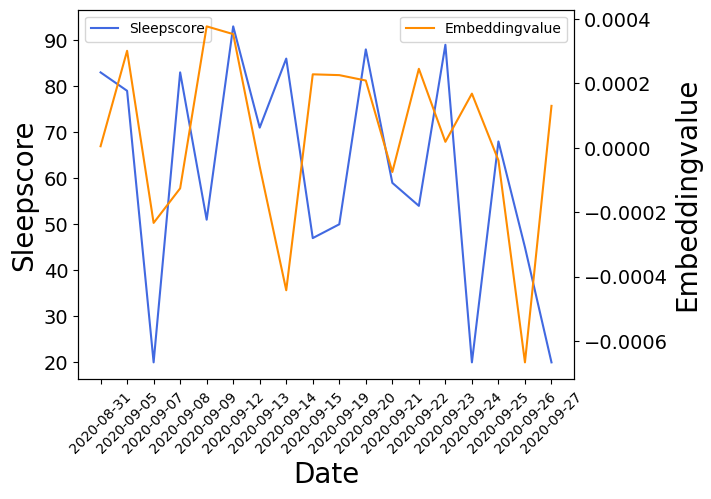

<Figure size 2000x2000 with 0 Axes>

In [ ]:
viz(vector_dictionary=vectors_dict_nongraph,sleepdf=usersleepdf)

/tmp/ipykernel_599538/190261156.py:25: UserWarning:

FixedFormatter should only be used together with FixedLocator



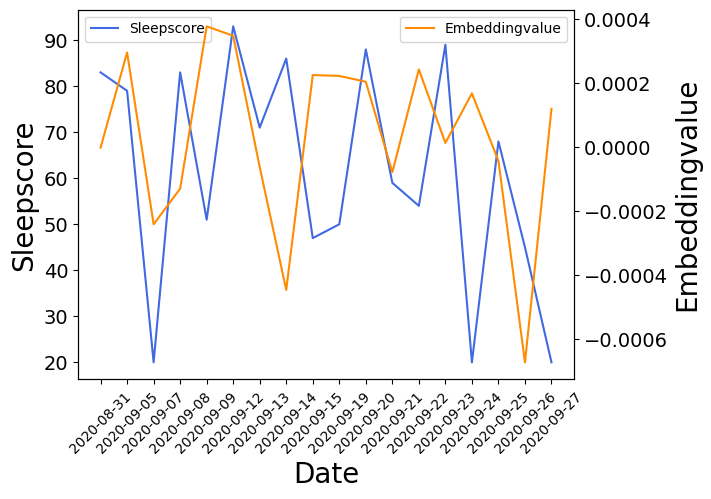

<Figure size 2000x2000 with 0 Axes>

In [ ]:
viz(vector_dictionary=vectors_dict,sleepdf=usersleepdf)

## correlation between sleepscore and embedding value

In [ ]:
from scipy.stats import pearsonr

def correlationvalue(vector_dictionary,sleepdf=usersleepdf):
    df = pd.DataFrame.from_dict(vector_dictionary).T
    df['mean'] = [df.iloc[i].mean() for i in range(len(df))]
    df = pd.merge(sleepdf, df.reset_index().rename(columns={'index':'date'}),how='inner',on='date')[['date','sleep_score','mean']]
    print(pearsonr(df['sleep_score'], df['mean']))

In [418]:
correlationvalue(vectors_dict)
correlationvalue(vectors_dict_nongraph)

PearsonRResult(statistic=0.04340619907024701, pvalue=0.8642113787413899)
PearsonRResult(statistic=0.04287192974614814, pvalue=0.8658683539344065)
